# Analysis of the Geant4 simulation of the NEBULA detector

In [46]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import norm
from sklearn.neighbors import KernelDensity

### Just some `matplotlib` and `seaborn` parameter tuning

In [2]:
axistitlesize = 26
axisticksize = 23
axislabelsize = 26
axislegendsize = 16
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 0. Parameters for the pipeline

In [139]:
DATADIR = '../project_nebula/data/'
OUTDIR = './out/'

In [287]:
# Energy of neutrons ([E] = 1)
E = 100
# NEBULA ROD COUNT
nrows = 2
ncols = 10

cols = np.array(['X', 'Y', 'Z', 'Edep', 'Part', 'Volume', 'Proc'])

## 1. Load output data of NEBULA simulation

In [288]:
physics = [
    "QBBC",
    "QGSP_BERT_HP",
    "QGSP_BIC_HP",
    "QGSP_INCLXX",
    "QGSP_INCLXX_HP"
]

In [291]:
def load_data(DATADIR, phys_name):
    
    proj_files = np.array(os.listdir(DATADIR + phys_name))
    proj_mask = np.array(['RodData_' in f for f in proj_files])
    proj_files = proj_files[proj_mask]

    # Read in data files from all threads
    data = []
    for f in proj_files:
        data.append(pd.read_csv(DATADIR + phys_name + '/' + f, skiprows=11, names=cols))

    return(pd.concat([d for d in data]))

In [292]:
data_QBBC = load_data(DATADIR=DATADIR, phys_name=physics[0])
data_QGSP_BERT_HP = load_data(DATADIR=DATADIR, phys_name=physics[1])
data_QGSP_BIC_HP = load_data(DATADIR=DATADIR, phys_name=physics[2])
data_QGSP_INCLXX = load_data(DATADIR=DATADIR, phys_name=physics[3])
data_QGSP_INCLXX_HP = load_data(DATADIR=DATADIR, phys_name=physics[4])

data = {
    n : p for n,p in zip
    (
        physics,
        [
            data_QBBC[cols],
            data_QGSP_BERT_HP[cols],
            data_QGSP_BIC_HP[cols],
            data_QGSP_INCLXX[cols],
            data_QGSP_INCLXX_HP[cols]
        ]
    )
}

## 2. Distribution of the total deposited energy among rods

In [293]:
cols_org = np.array(["Counter{}".format(i) for i in range(nrows*ncols)]).reshape(ncols, nrows).T

data_summed = {
    k : (v[['Edep', 'Volume']].groupby(['Volume']).sum().T)[cols_org.flatten()] for k,v in data.items()
}
data_org = {
    k : np.array(v).reshape(nrows,ncols) for k,v in data_summed.items()
}

In [294]:
def plot_nebula_rod_intensity(phys_name, data_org, cols_org, OUTDIR):
    
    fig, axes = plt.subplots(figsize=(15,15),
                             facecolor='.1')
    axes.set_aspect('equal')
    axes.axis('off')

    axes.matshow(data_org, cmap=cm.magma)
    for X in range(cols_org.shape[0]):
        for Y in range(cols_org.shape[1]):
            axes.text(Y, X, cols_org[X, Y], fontsize=12,
                      ha='center', va='center', color='ghostwhite', fontweight='bold', 
                      bbox=dict(color=np.array((0,0,0,0.2)), lw=0)
                     )
    axes.set_title('Current phys : {}'.format(phys_name), fontsize=axistitlesize, fontweight='bold', color='white')
    
    plt.suptitle('$\\Uparrow$ Beam comes from this direction $\\Uparrow$',
                 fontsize=axistitlesize+5, y=0.4, color='ghostwhite', fontweight='bold')

    if not os.path.exists(OUTDIR):
        os.makedirs(OUTDIR)
    plt.savefig(OUTDIR + 'rod_heatmap_E{0}_ph{1}.png'.format(E, phys_name),
                format='png', dpi=200,
                facecolor='black', edgecolor='black',
                bbox_inches='tight')

    plt.show()

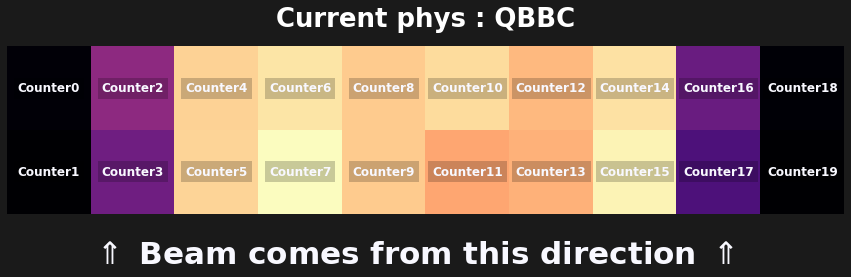

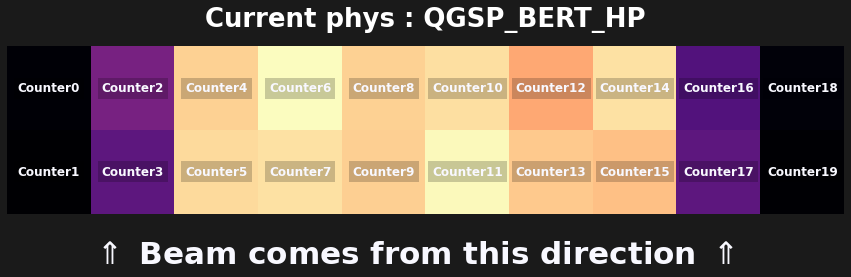

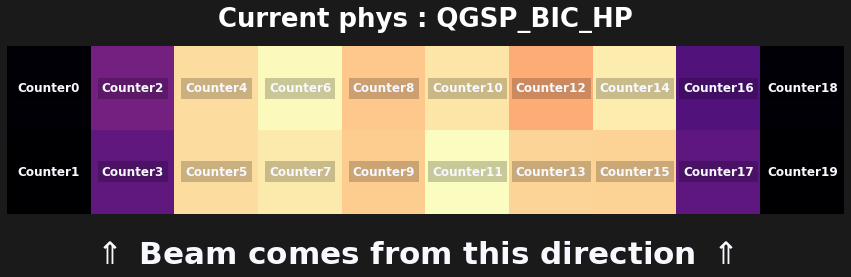

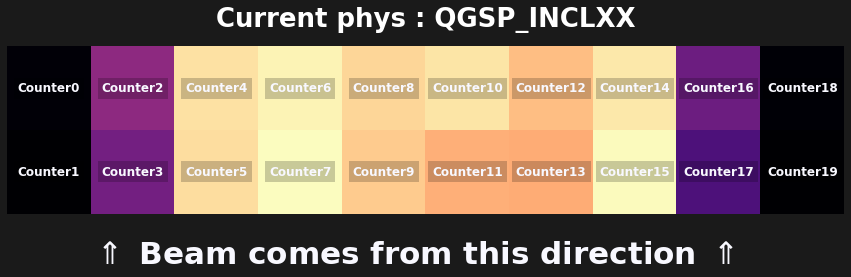

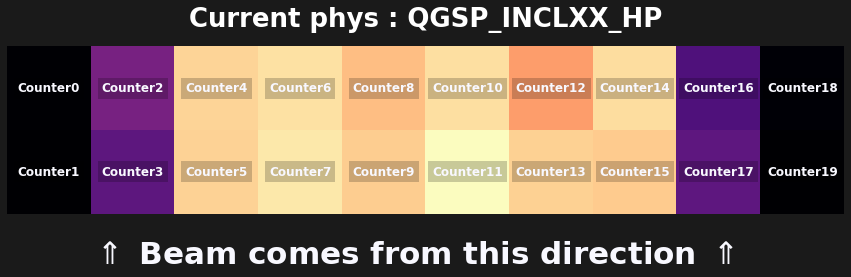

In [295]:
for phys_name in physics:
    plot_nebula_rod_intensity(phys_name, data_org[phys_name], cols_org, OUTDIR)

## 3. Energy distribution of neutrons per rods

In [258]:
cols_hist = cols_org.flatten()

In [148]:
hist = {}
bins = {}
width = {}
center = {}

for phys_name in physics:
    
    data_ph = data_edep[phys_name]
    
    hist_ph = {}
    bins_ph = {}
    width_ph = {}
    center_ph = {}
    
    for c in cols_hist:
        data_phc = np.array(data_ph[c])
        data_phc = data_phc[data_phc > 0.1]
        hist_ph[c], bins_ph[c] = np.histogram(data_phc, bins=30, density=False)
        width_ph[c] = 0.8 * (bins_ph[c][1] - bins_ph[c][0])
        center_ph[c] = (bins_ph[c][:-1] + bins_ph[c][1:]) / 2
        
    hist[phys_name] = hist_ph
    bins[phys_name] = bins_ph
    width[phys_name] = width_ph
    center[phys_name] = center_ph

In [149]:
def plot_nebula_bar_dist(phys_name, center, hist, width, cols_hist, OUTDIR):
    
    ncols = 10
    nrows = (cols_hist.size+ncols-1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5, nrows*4.5),
                             facecolor='.1', subplot_kw={'facecolor' : 'black'})
    fig.subplots_adjust(hspace=0.35, wspace=0.35)

    color = cm.magma(0.85)
    # Loop through axes/rods
    for col_i, ax in enumerate(axes.reshape(-1)):
        # Turn off all surplus axes
        if col_i < cols_hist.size:
            col = cols_hist[col_i]
            #ax.set_yscale('log')
            ax.bar(center[col], hist[col], width=width[col],
                   color=color, alpha=0.7,
                   ec='black', lw=0.5, align='center')
            #ax.set_xlim(0,12.5)
            
            ax.set_title(col, fontsize=axistitlesize-5, fontweight='bold', color='white')
            ax.set_xlabel('Dep. Energy [MeV]', fontsize=10, fontweight='bold', color='white')
            ax.set_ylabel('Occurence', fontsize=10, fontweight='bold', color='white')
            ax.tick_params(axis='both', which='major', labelsize=12, colors='white')
            ax.tick_params(axis='y', which='major', labelsize=12, colors='white', rotation=42)
            
        else : ax.axis('off')
    
    plt.suptitle('$\\Uparrow$ Beam comes from this direction $\\Uparrow$\n' +
                 'Current phys : {}'.format(phys_name),
                 fontsize=axistitlesize+20, y=0.03, color='ghostwhite', fontweight='bold')

    if not os.path.exists(OUTDIR):
        os.makedirs(OUTDIR)
    plt.savefig(OUTDIR + 'energy_dist_per_rod_E{0}_ph{1}.png'.format(E, phys_name),
                format='png', dpi=200,
                facecolor='black', edgecolor='black',
                bbox_inches='tight')

    plt.show()

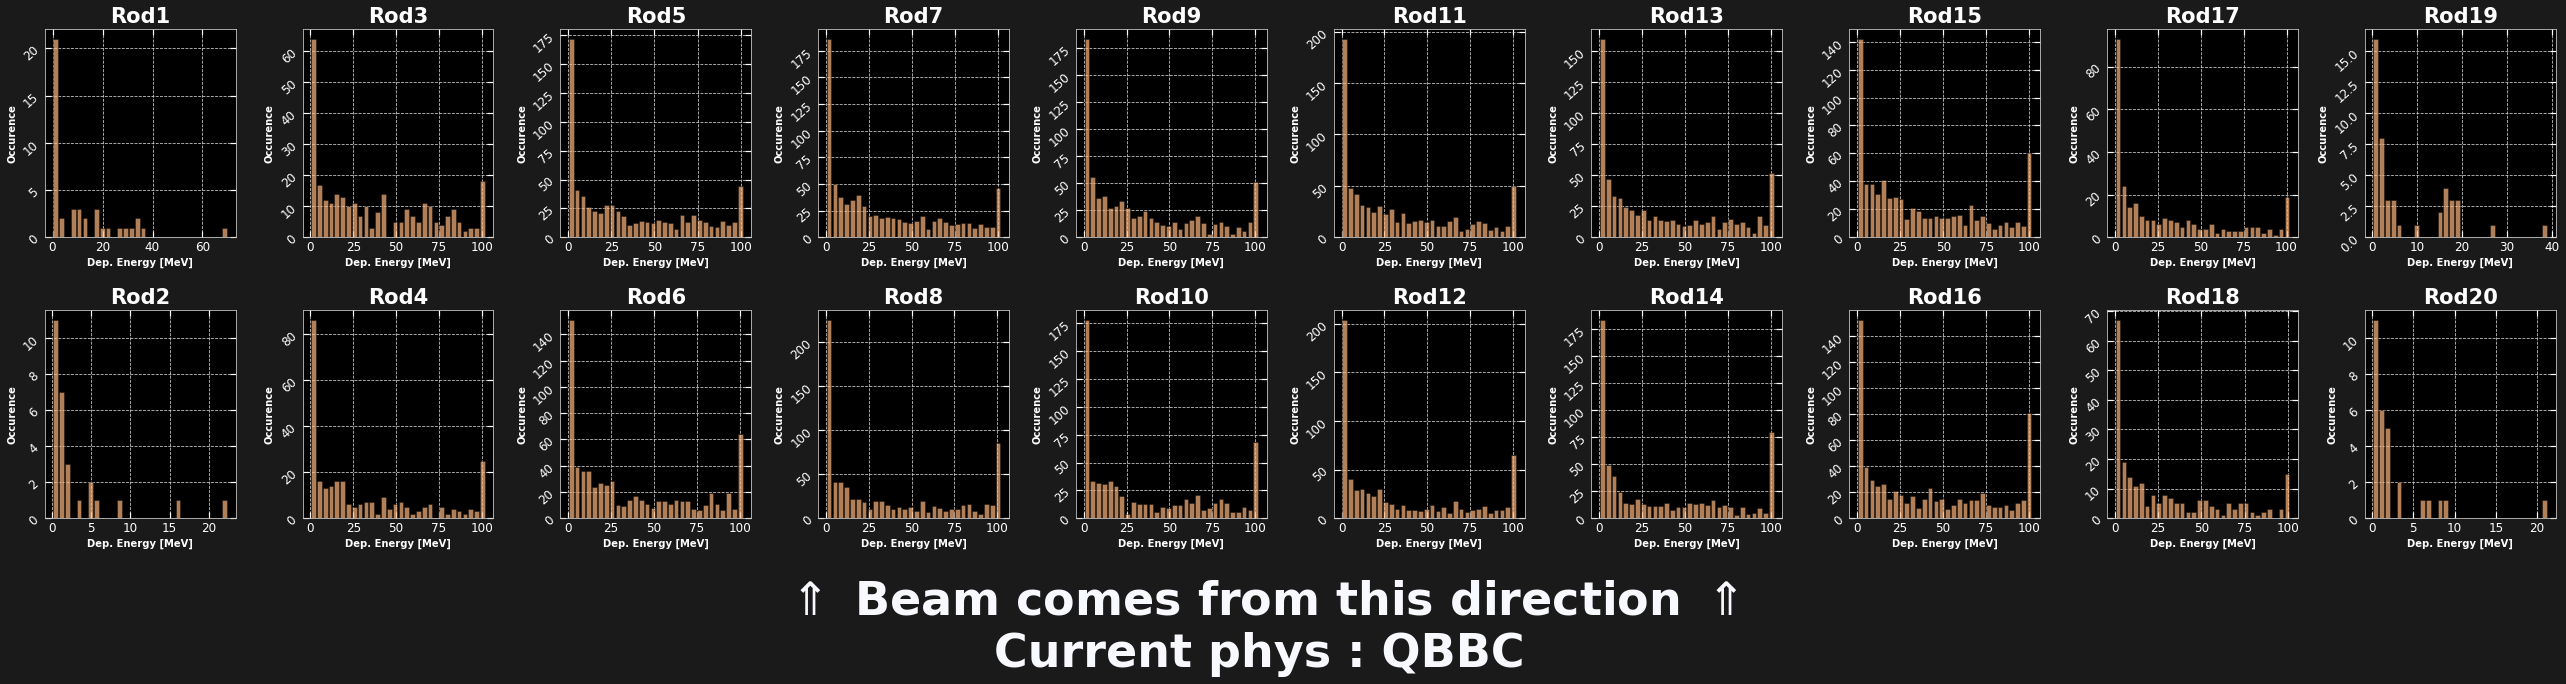

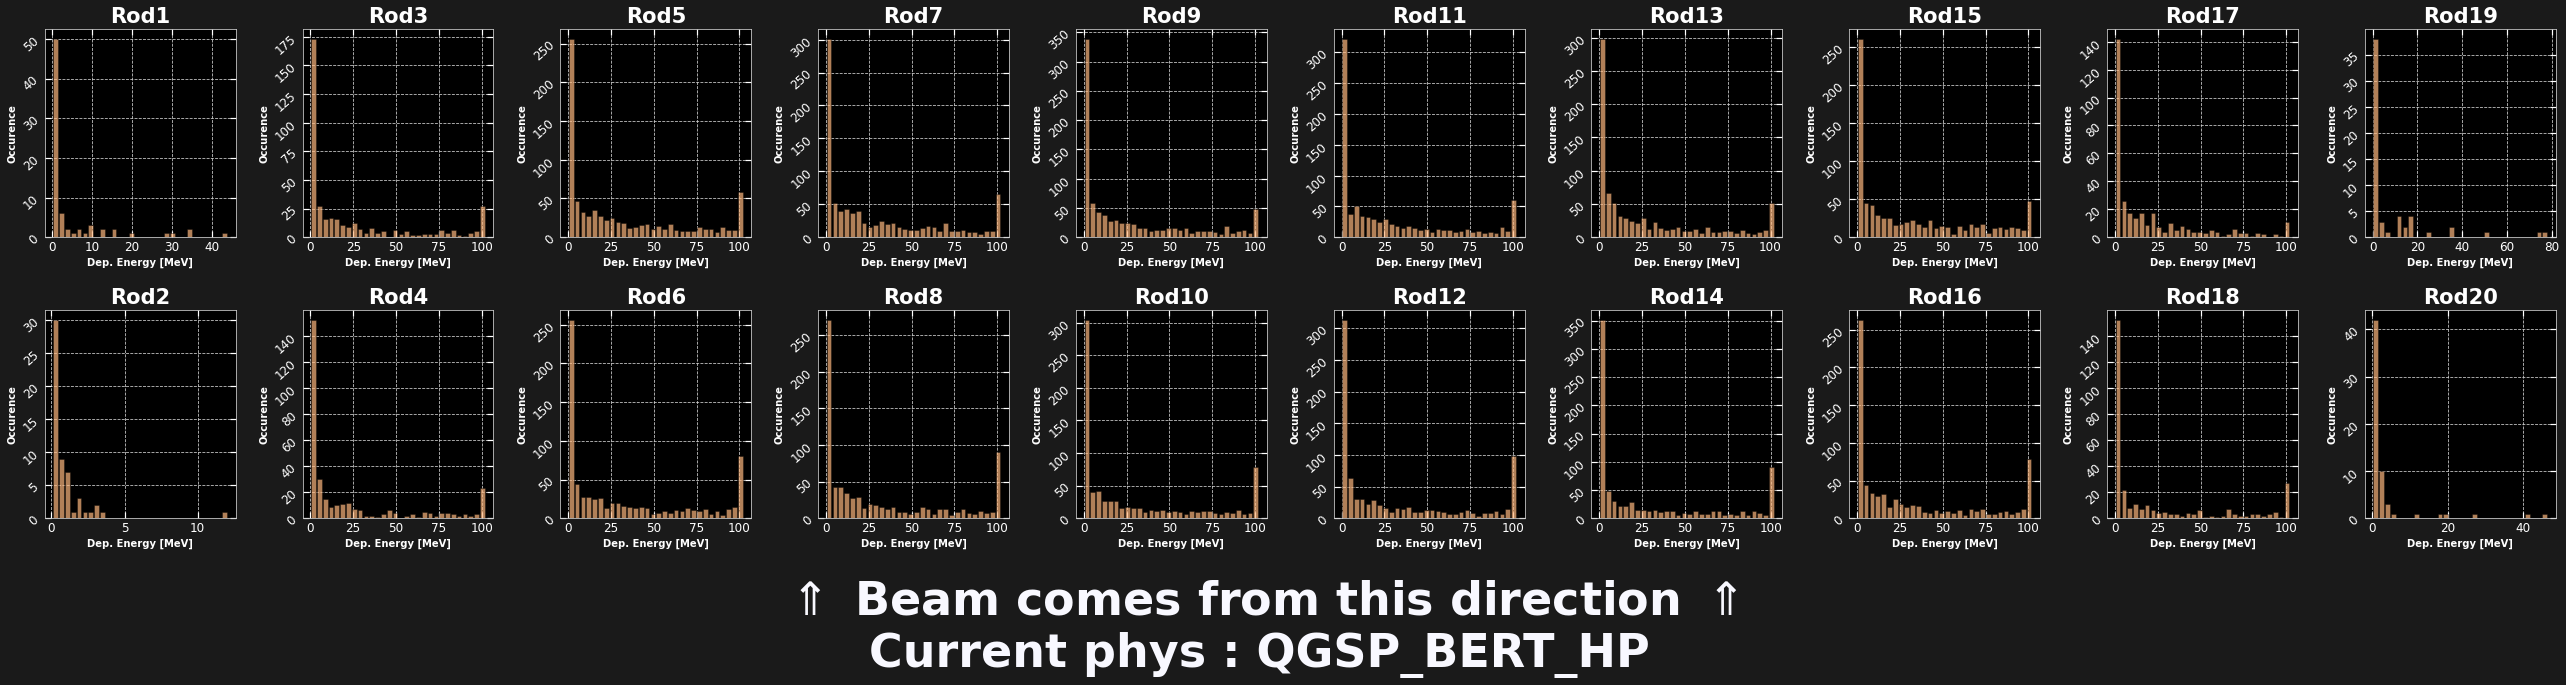

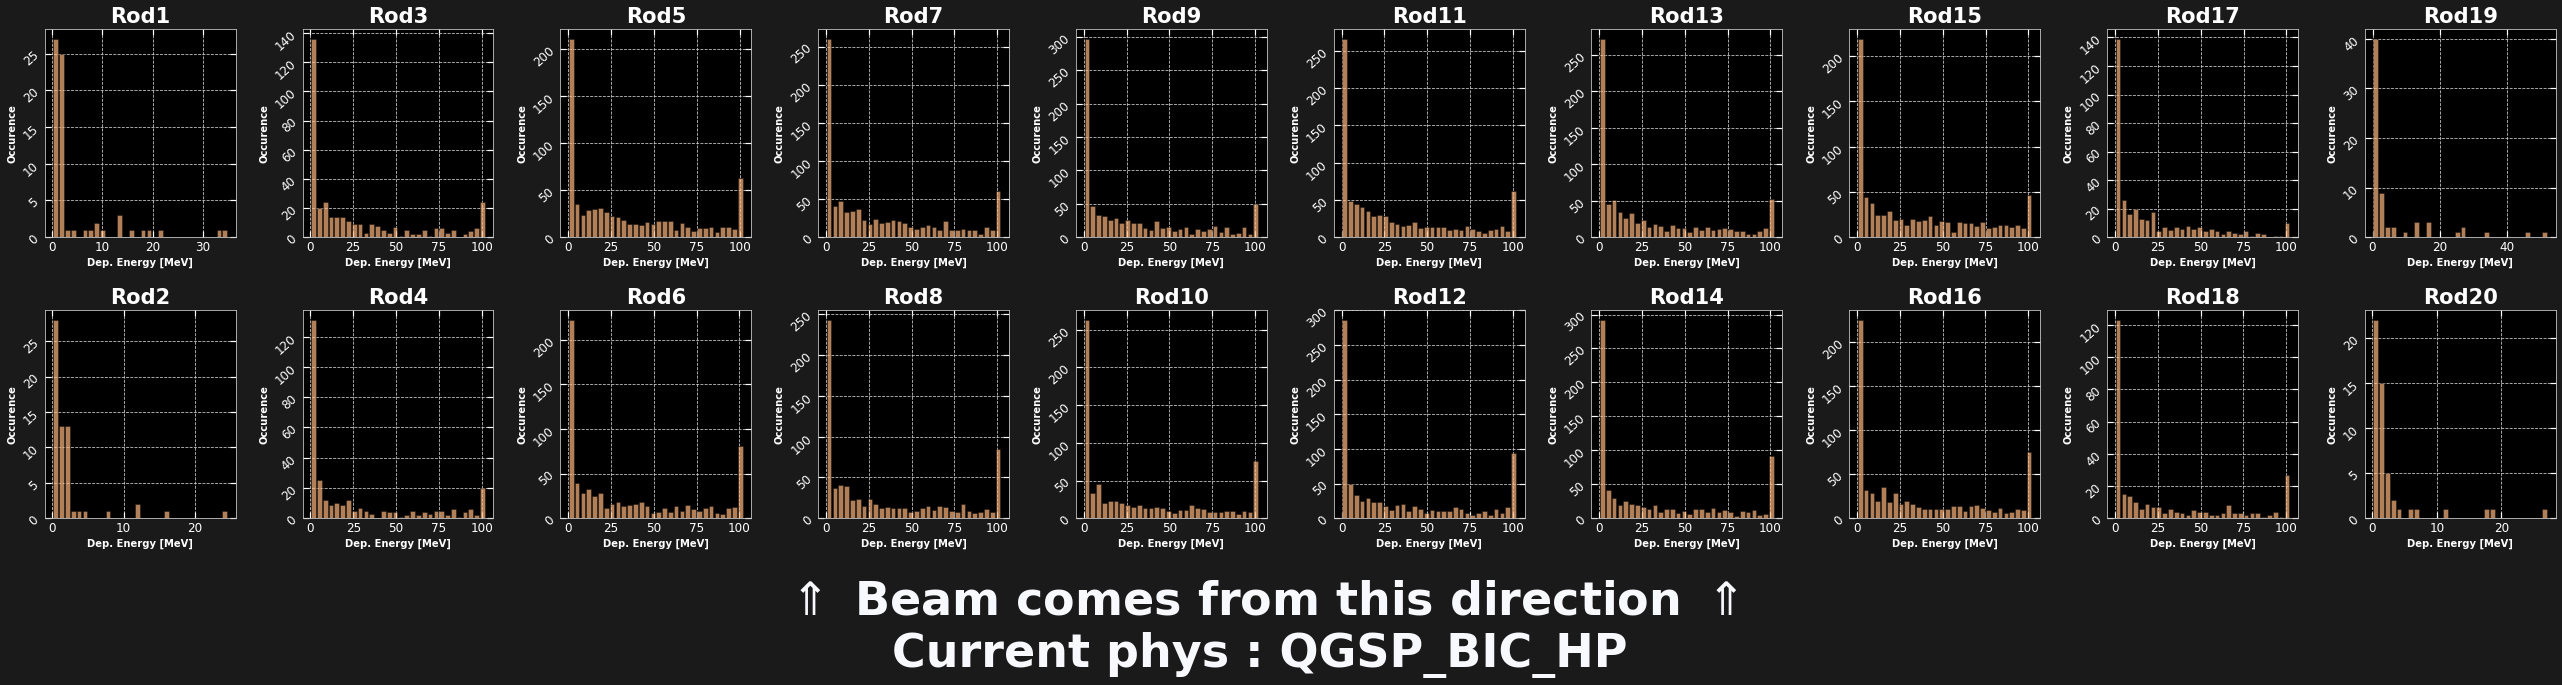

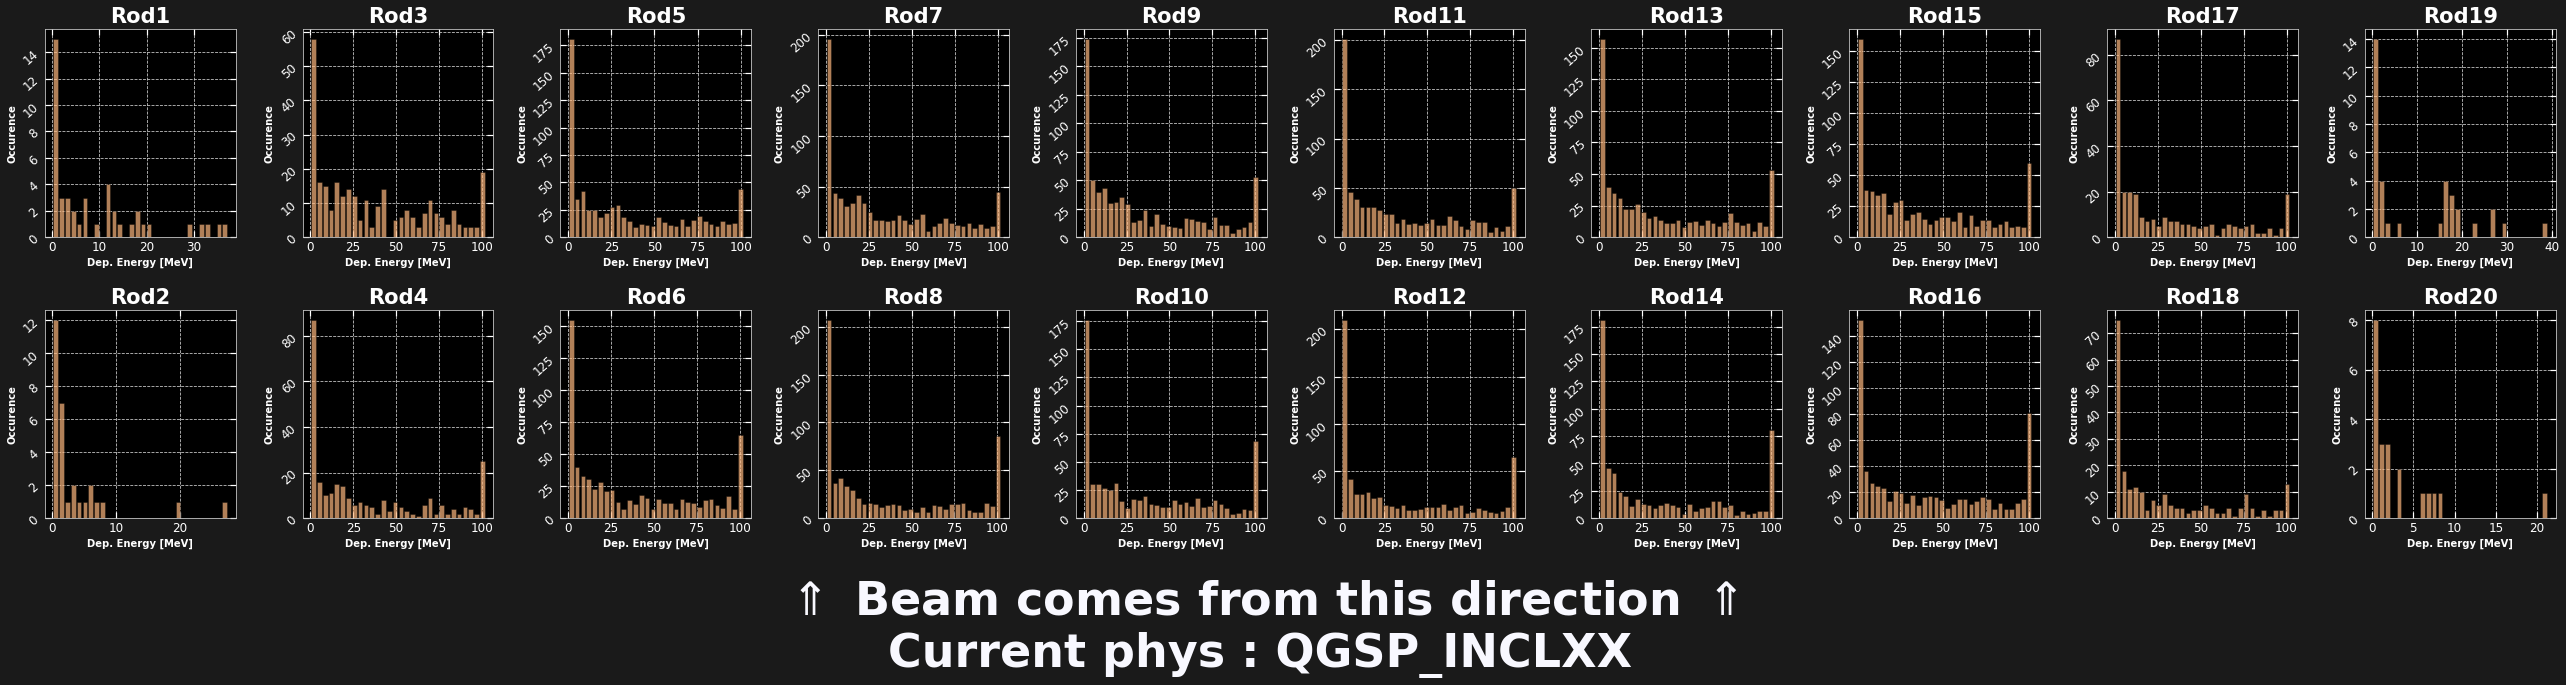

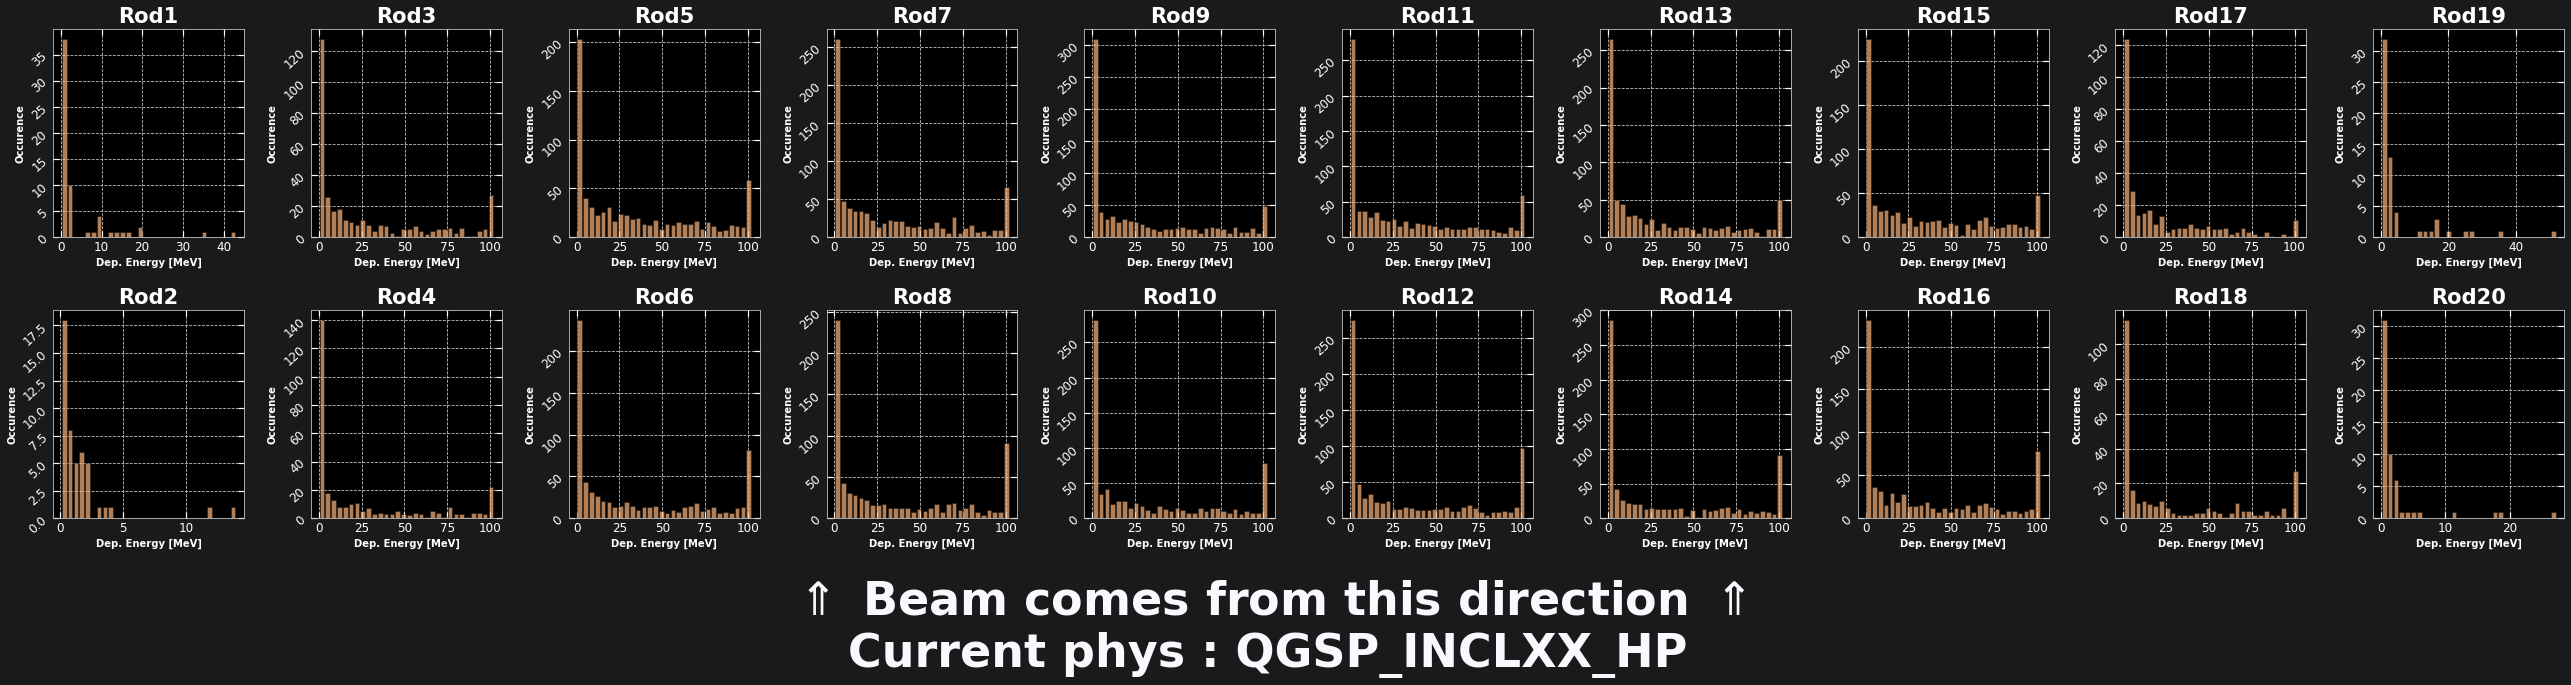

In [150]:
for phys_name in physics:
    plot_nebula_bar_dist(phys_name, center[phys_name], hist[phys_name], width[phys_name], cols_hist, OUTDIR)

## 4. Distribution of energy deposit for neutrons

In [157]:
def energy_dist_full(phys_name, data, OUTDIR):
    
    fig, axes = plt.subplots(figsize=(14, 10),
                             facecolor='.1', subplot_kw={'facecolor' : '.6'})

    colors = ['navy', 'cornflowerblue', 'darkorange']
    kernels = ['gaussian', 'tophat', 'epanechnikov']
    lw = 3

    Y = data.reshape(-1,1)
    X = np.linspace(0, np.max(Y), 1000)[:, np.newaxis]
    for color, kernel in zip(colors, kernels):
        kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(Y)
        log_dens = kde.score_samples(X)
        axes.plot(X[:,0], np.exp(log_dens), color=color, lw=lw,
                  linestyle='-', label="kernel = '{0}'".format(kernel))

    axes.set_ylim(-0.005,0.1)
    
    axes.set_title('Current phys : {}'.format(phys_name), fontsize=axistitlesize, fontweight='bold', color='white')
    axes.set_xlabel('Dep. Energy [MeV]', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.set_ylabel('Relative occurence', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
    axes.tick_params(axis='y', which='major', labelsize=axisticksize, colors='white', rotation=42)

    axes.legend(loc='upper left', fontsize=axislegendsize)
    
    if not os.path.exists(OUTDIR):
        os.makedirs(OUTDIR)
    plt.savefig(OUTDIR + 'energy_dist_full_E{0}_ph{1}.png'.format(E, phys_name),
                format='png', dpi=200,
                facecolor='black', edgecolor='black',
                bbox_inches='tight')
    
    plt.show()

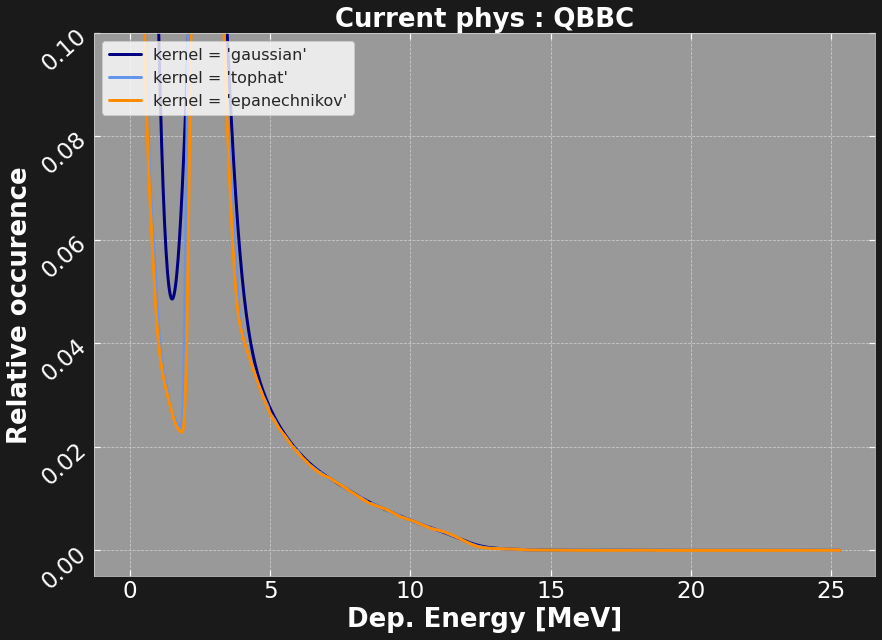

KeyboardInterrupt: 

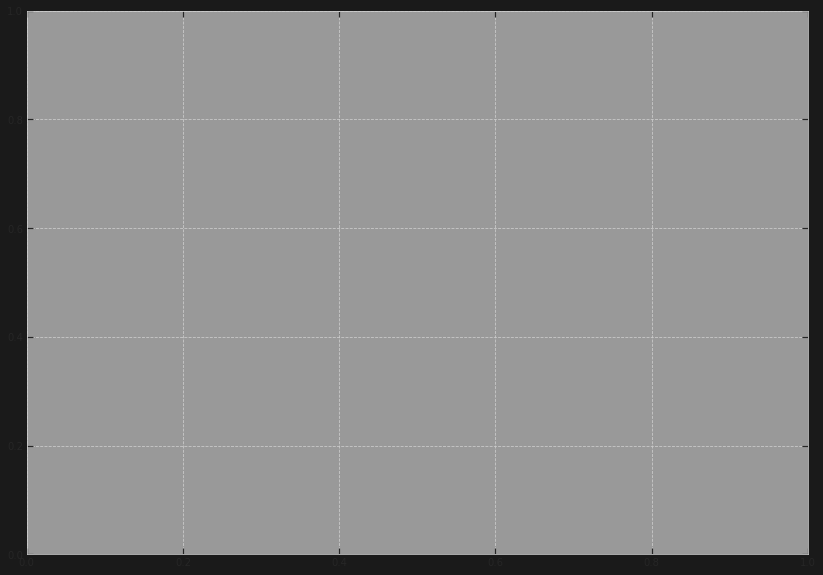

In [262]:
for phys_name in physics:
    data_flt = np.array(data[phys_name]['Edep'])
    data_flt = data_flt[data_flt > 0]
    energy_dist_full(phys_name, data_flt, OUTDIR)

In [278]:
kdes = {p : {} for p in physics}

kernel = 'epanechnikov' # ['gaussian', 'tophat', 'epanechnikov']
for phys_name in physics:

    data_flt = np.array(data[phys_name].loc[(data[phys_name]['Volume'].str.startswith('Counter')),['Edep']])
    kdes[phys_name]['Y'] = data_flt.reshape(-1, 1)
    kdes[phys_name]['X'] = np.linspace(0, np.max(kdes[phys_name]['Y']), 1000)[:, np.newaxis]
    kdes[phys_name]['kde'] = KernelDensity(kernel=kernel, bandwidth=0.5).fit(kdes[phys_name]['Y'])
    kdes[phys_name]['log_dens'] = kdes[phys_name]['kde'].score_samples(kdes[phys_name]['X'])

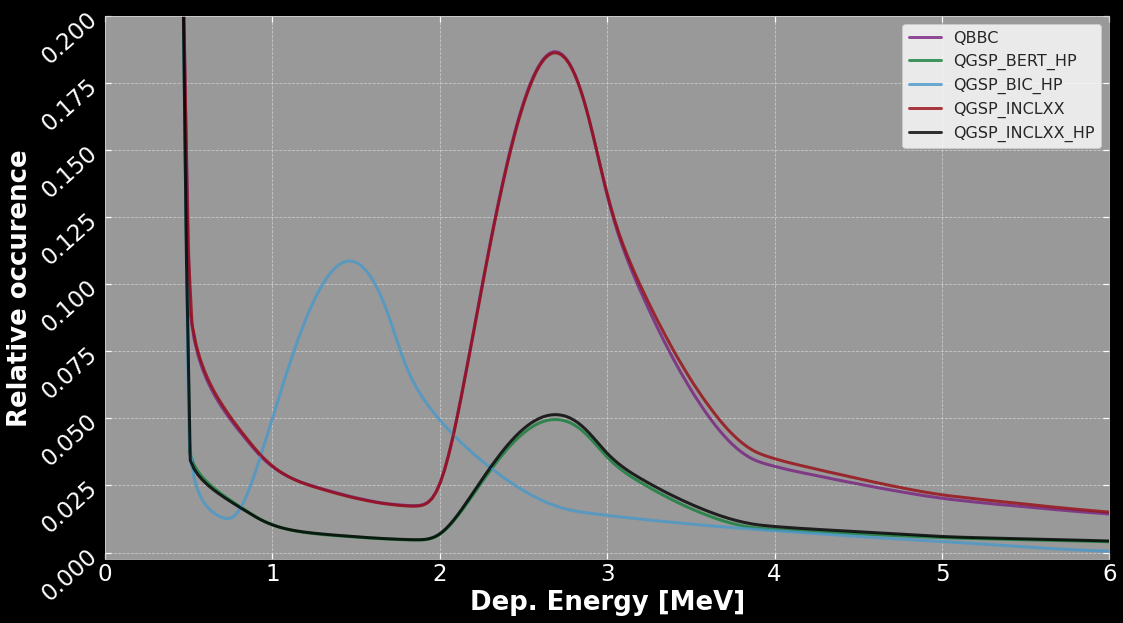

In [286]:
fig, axes = plt.subplots(figsize=(18, 10),
                         facecolor='black', subplot_kw={'facecolor' : '.6'})

colors = [
    cm.magma(0.35),
    cm.Greens(0.8),
    cm.Blues(0.6),
    cm.Reds(0.9),
    'black'
]

for color, phys_name in zip(colors, physics):
    
    X = kdes[phys_name]['X']
    log_dens = kdes[phys_name]['log_dens']
    axes.plot(X[:,0], np.exp(log_dens), color=color, lw=3, alpha=0.8,
              linestyle='-', label=phys_name)

axes.set_xlim(0, 6)
axes.set_ylim(-0.0025, 0.2)

axes.set_xlabel('Dep. Energy [MeV]', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('Relative occurence', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
axes.tick_params(axis='y', which='major', labelsize=axisticksize, colors='white', rotation=42)

axes.legend(loc='upper right', fontsize=axislegendsize)

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)
plt.savefig(OUTDIR + 'energy_dist_full_concat_E{0}.png'.format(E),
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')

plt.show()

In [204]:
def processes_in_range(physics, data_edep, data_proc, E_range=(98,102)):

    uniques = {}
    for phys_name in physics:
        e = np.array(data_edep[phys_name]).reshape(-1,)
        p = np.array(data_proc[phys_name]).reshape(-1,)
        mask = (e > E_range[0]) & (e < E_range[1])
        uniques[phys_name] = np.unique(p[mask], return_counts=True)
        
    return uniques

In [213]:
proc_E60_80 = processes_in_range(physics, data, E_range=(60,80))

In [218]:
uniques[physics[3]]

(array(['Decay', 'Transportation', 'hIoni', 'ionIoni'], dtype=object),
 array([ 14,  83, 851,  60]))